In [25]:
# import library 
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# read the data (test data)
data = pickle.load(open('../../Dataset/histopathology/histopathology.pkl', 'rb'),encoding='latin1')
print(data.keys())

test_data = data['test']

dict_keys(['test', 'training', 'validation'])


(2000, 28, 28)


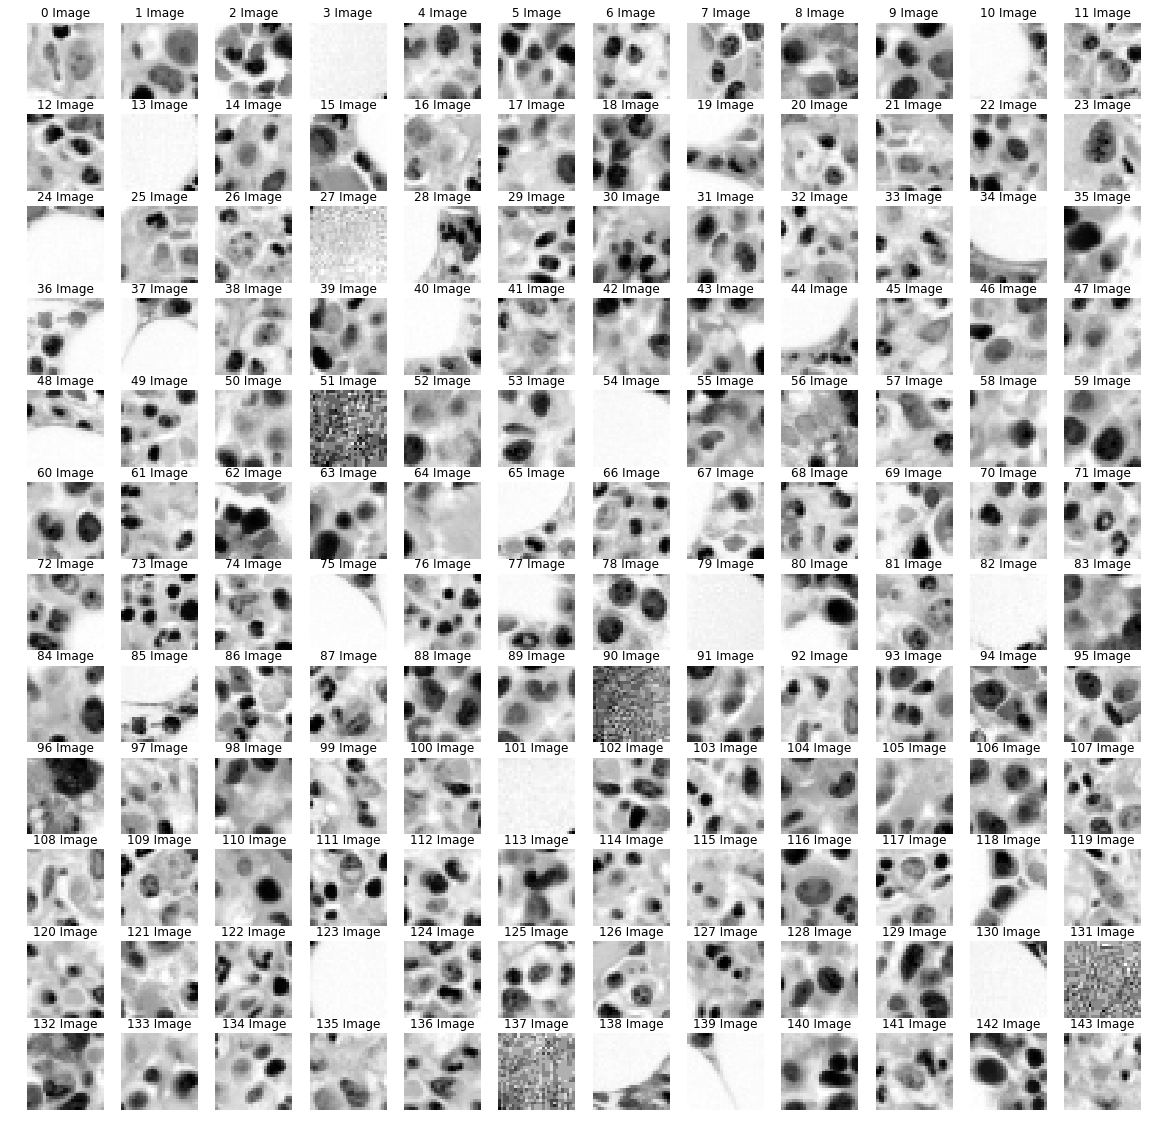

In [33]:
test_data = np.asarray(test_data)
print(test_data.shape)
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(test_data[i-1],cmap='gray')
    plt.axis('off')
    plt.title(str(i-1) + ' Image')
plt.show()

In [ ]:
! git add .
! git commit -m "from mac"
! git push